In [18]:
import os
import torch
import pandas as pd
import PIL
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from pathlib import Path
# Ignore warnings
import warnings
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


In [19]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        id, landmarks = sample['id'], sample['landmarks']

       
        
        return {'id': torch.Tensor(id),
                'landmarks': torch.from_numpy(landmarks)}
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)

In [20]:
import os
 
import pandas as pd
import numpy as np
import PIL

class FaceLandmarksDataset(Dataset):
    def __init__(self, root_dir, landmarks_extension, transform=None):
        self.root_dir: Path = Path(root_dir)
        self.transform = transform
        self.landmarks_extension = landmarks_extension
        
        
        data = self.set_data_paths(root_dir, ["*.jpg", "*.png"])
        
        
        self.df = self.make_csv(data)
        self.max_landmarks = self.get_max_landmarks()
        self.num_of_classes=self.df['id'].nunique()
        print(f"num of classes:{self.num_of_classes}")
    def get_max_landmarks(self):
        max_landmarks = 0
        for idx in range(len(self.df)):
            landmarks_path = self.df.iloc[idx]["landmark_path"]
            landmarks = np.load(landmarks_path)
            max_landmarks = max(max_landmarks, len(landmarks))
        return max_landmarks
    def set_data_paths(self, root_dir, extensions: list = list) -> dict:
        all_names = os.listdir(root_dir)
        data_paths = {}
        for name in all_names:
            new_path = self.root_dir.joinpath(name)
            paths = []
            for ext in extensions:
                paths += list(new_path.rglob(ext))
            data_paths[name] = paths
        return data_paths

    def get_landmark_path(self, path):
        landmarks_path = Path(str(path)[:-4] + self.landmarks_extension)
        return landmarks_path

    def make_csv(self, data: dict):
        records = []
        name_count = 0
        for name, paths in data.items():
            flag=False
            for path in paths:
                landmarks_path = self.get_landmark_path(path)
                if landmarks_path.exists() and path.exists():
                    records.append({
                        "image_path": str(path),
                        "landmark_path": str(landmarks_path),
                        "name": name,
                        "id":name_count
                    })
                    flag=True
            if flag:
                name_count += 1

        df = pd.DataFrame(records)
       
        return df

    def __len__(self):
        return len(self.df)
    def pad_landmarks(self, landmarks):
        padded_landmarks = np.zeros((self.max_landmarks, landmarks.shape[1]))
        padded_landmarks[:landmarks.shape[0], :] = landmarks
        return padded_landmarks
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        #img_path = self.df.iloc[idx]["image_path"]
        landmarks_path = self.df.iloc[idx]["landmark_path"]
        id = self.df.iloc[idx]["id"]

        #image = PIL.Image.open(img_path)
        #image = np.array(image)
        #assert image.size != 0, f"[ERROR] The image {img_path} is empty or cannot be read."
        
        landmarks = np.load(landmarks_path)
        #landmarks = self.pad_landmarks(landmarks)
        sample = {'id': id, 'landmarks': torch.tensor(landmarks, dtype=torch.float32)}

        if self.transform:
            sample = self.transform(sample)

        return sample

face_dataset = FaceLandmarksDataset(root_dir='./dataset_not_for_upload_images',
                                    landmarks_extension="_landmarks.npy",)
dataloader = DataLoader(face_dataset, batch_size=4,
                        shuffle=True, num_workers=0)

# for i, sample in enumerate(dataloader):
#     print(i, sample['id'].size(), sample['landmarks'].size())

#     if i == 3:
#        
#  break
face_dataset.df["id"]

num of classes:25


0        0
1        0
2        0
3        0
4        0
        ..
1496    23
1497    23
1498    24
1499    24
1500    24
Name: id, Length: 1501, dtype: int64

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer



class LandmarkClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LandmarkClassifier, self).__init__()

        # 1D Convolution layers
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=64, kernel_size=3, padding=1)
        #self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        #self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * int(input_size/2), 512)  # First fully connected layer after Conv1D
        self.bone = nn.ModuleList([nn.Linear(512, 512) for _ in range(4)])  # Bone layers
        self.fcsl = nn.Linear(512, 256)  # Second FC layer
        self.fcl = nn.Linear(256, num_classes)  # Output layer

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)  # Dropout to prevent overfitting
    def update_model_for_new_dataset(self,output_size,):
        self.fcl=nn.Linear(256, output_size)
    def forward(self, x):
        
        x = x.permute(0, 3, 2, 1)  
        x = x.squeeze(-1) 
           
        x = self.relu(self.conv1(x))
        #print(f"shape:{x.shape}")
        #x = self.relu(self.conv2(x))
        #x = self.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        
        for fc in self.bone:
            x = self.relu(fc(x))
            x = self.dropout(x)
        x = self.dropout(x)
        
        x = self.relu(self.fcsl(x))
        
        logits = self.fcl(x)
        probs = F.softmax(logits, dim=1)  # Apply softmax to get probabilities

        return probs, logits




# Loss function and optimizer
input_size = 136  # 68 landmarks * 2 (x, y coordinates)
num_classes = face_dataset.num_of_classes  # Replace with your actual number of classes
# Example Usage
patch_size = 2  # Number of landmarks per patch
num_patches = input_size // patch_size  # Number of patches
dim = 64  # Embedding dimension
num_heads = 10  # Number of attention heads
num_layers = 4  # Number of transformer encoder layers
mlp_dim = 256  # Dimension of MLP in transformer
model = LandmarkClassifier(input_size=input_size,num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Load the checkpoint
path='./weights/weight_basic.pth'
def get_checkpoint(path):
    checkpoint = torch.load(path)
# Optionally, restore other data
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(f"epoch:{epoch}")
    print(f"loss:{loss}")
    return checkpoint

checkpoint = get_checkpoint(path)
model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
#model.update_model_for_new_dataset(face_dataset.num_of_classes)

# Training function
def train_model(model, dataloader, num_epochs=10):
    model.train()  # Set the model to training mode
    loss_history = []

    for epoch in  range(num_epochs):
        running_loss = 0.0

        for i, sample in enumerate(dataloader):
            landmarks = sample['landmarks']  # Shape: (batch_size, 68, 2)
            ids = sample['id']  # Class labels (target)

            # Forward pass
            probs, logits = model(landmarks)
            loss = criterion(logits, ids)  # Use logits in loss computation

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(dataloader)
        loss_history.append(epoch_loss)
        
        #scheduler.step()

    # Optionally print out the learning rate for each epoch
        #current_lr = optimizer.param_groups[0]['lr']
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f} ")

    return loss_history


epoch:300
loss:2.2347372429485017


In [31]:
# Train the model and capture the loss history
loss_history = train_model(model, dataloader, num_epochs=200)

# # Plot the loss curve
# plt.figure(figsize=(10, 5))
# plt.plot(loss_history, label="Loss")
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.title("Training Loss Curve")
# plt.legend()
# plt.show()
loss_history

Epoch [1/200], Loss: 2.3147 
Epoch [2/200], Loss: 2.3584 
Epoch [3/200], Loss: 2.2704 
Epoch [4/200], Loss: 2.2805 
Epoch [5/200], Loss: 2.2255 
Epoch [6/200], Loss: 2.2781 
Epoch [7/200], Loss: 2.4444 
Epoch [8/200], Loss: 2.1763 
Epoch [9/200], Loss: 2.2266 
Epoch [10/200], Loss: 2.3230 
Epoch [11/200], Loss: 2.3674 
Epoch [12/200], Loss: 2.2803 
Epoch [13/200], Loss: 2.3059 
Epoch [14/200], Loss: 2.3824 
Epoch [15/200], Loss: 2.3520 
Epoch [16/200], Loss: 2.3859 
Epoch [17/200], Loss: 2.3253 
Epoch [18/200], Loss: 2.5489 
Epoch [19/200], Loss: 2.4094 
Epoch [20/200], Loss: 2.2983 
Epoch [21/200], Loss: 2.4080 
Epoch [22/200], Loss: 2.3950 
Epoch [23/200], Loss: 2.3939 
Epoch [24/200], Loss: 2.3315 
Epoch [25/200], Loss: 2.2472 
Epoch [26/200], Loss: 2.3389 
Epoch [27/200], Loss: 2.3522 
Epoch [28/200], Loss: 2.2757 
Epoch [29/200], Loss: 2.4820 
Epoch [30/200], Loss: 2.4804 
Epoch [31/200], Loss: 2.1887 
Epoch [32/200], Loss: 2.3449 
Epoch [33/200], Loss: 2.3337 
Epoch [34/200], Los

[2.3147476445487203,
 2.358394690095744,
 2.270364209969944,
 2.280512178049205,
 2.225518717282226,
 2.2781315830318216,
 2.444422737053754,
 2.1762838469857866,
 2.226634712295329,
 2.3230399398252053,
 2.3674447666457357,
 2.2802650447380035,
 2.305920398853561,
 2.38237394796724,
 2.3519700414481317,
 2.3858812439473387,
 2.3252769949588368,
 2.5489062142181904,
 2.409407712677692,
 2.298262099794885,
 2.407977022072102,
 2.3949969269018223,
 2.393912470721184,
 2.3315215351452006,
 2.247188368891465,
 2.3388795911411395,
 2.352203091447975,
 2.2757216446260187,
 2.481998128697593,
 2.4804050371526403,
 2.1887179922233235,
 2.3449462391981024,
 2.3337355815666787,
 2.3026665298545614,
 2.4969908160732146,
 2.397083988115984,
 2.312421318302129,
 2.296256061643362,
 2.379039487623154,
 2.43058846712588,
 2.4079169000082827,
 2.4297546192686608,
 2.449806721682878,
 2.3984303529909314,
 2.4037153741463704,
 2.3140426847211857,
 2.3705996360550534,
 2.405324061341742,
 2.5328854958110

In [145]:
face_dataset.df[["name","id"]].groupby(["name","id"]).mean().reset_index().to_csv("./weights/name_id.csv")

In [14]:
ids_name=face_dataset.df[["name","id"]].groupby(["name","id"]).mean().reset_index()
def get_class_name(ids_name,pred_id):
    name=ids_name[ids_name["id"]==pred_id]["name"].values[-1]
    return name 


In [15]:
#from custom_dataset.face_img_landmarks import FaceImageLandmarksDataset
from torchvision import transforms
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)
        transform=transforms.Resize(((new_h, new_w)))
        img = transform(image )

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        scale_factors = torch.tensor([new_w / w, new_h / h], dtype=torch.float32)
        landmarks = landmarks * scale_factors

        return {'image': img, 'landmarks': landmarks}


class FaceImageLandmarksDataset(Dataset):
    def __init__(self, root_dir, landmarks_extension, transform=None):
        self.root_dir: Path = Path(root_dir)
        self.transform = transform
        self.landmarks_extension = landmarks_extension
        
        
        data = self.set_data_paths(root_dir, ["*.jpg", "*.png"])
        
        
        self.df = self.make_csv(data)
        self.max_landmarks = self.get_max_landmarks()
        self.num_of_classes=self.df['id'].nunique()
        print(f"num of classes:{self.num_of_classes}")
    def get_max_landmarks(self):
        max_landmarks = 0
        for idx in range(len(self.df)):
            landmarks_path = self.df.iloc[idx]["landmark_path"]
            landmarks = np.load(landmarks_path)
            max_landmarks = max(max_landmarks, len(landmarks))
        return max_landmarks
    def set_data_paths(self, root_dir, extensions: list = list) -> dict:
        all_names = os.listdir(root_dir)
        data_paths = {}
        for name in all_names:
            new_path = self.root_dir.joinpath(name)
            paths = []
            for ext in extensions:
                paths += list(new_path.rglob(ext))
            data_paths[name] = paths
        return data_paths

    def get_landmark_path(self, path):
        landmarks_path = Path(str(path)[:-4] + self.landmarks_extension)
        return landmarks_path

    def make_csv(self, data: dict):
        records = []
        name_count = 0
        for name, paths in data.items():
            flag=False
            for path in paths:
                landmarks_path = self.get_landmark_path(path)
                if landmarks_path.exists() and path.exists():
                    records.append({
                        "image_path": str(path),
                        "landmark_path": str(landmarks_path),
                        "name": name,
                        "id":name_count
                    })
                    flag=True
            if flag:
                name_count += 1

        df = pd.DataFrame(records)
       
        return df

    def __len__(self):
        return len(self.df)
    def pad_landmarks(self, landmarks):
        padded_landmarks = np.zeros((self.max_landmarks, landmarks.shape[1]))
        padded_landmarks[:landmarks.shape[0], :] = landmarks
        return padded_landmarks
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.df.iloc[idx]["image_path"]
        landmarks_path = self.df.iloc[idx]["landmark_path"]
        id = self.df.iloc[idx]["id"]

        image = PIL.Image.open(img_path)
        image = np.array(image)
        assert image.size != 0, f"[ERROR] The image {img_path} is empty or cannot be read."
        
        landmarks = np.load(landmarks_path)
        #landmarks = self.pad_landmarks(landmarks)
        sample = {'id': id, 'landmarks': torch.tensor(landmarks, dtype=torch.float32),'image': torch.tensor(image, dtype=torch.float32)}

        if self.transform:
            sample = self.transform(sample)

        return sample
    
    

face_image_dataset = FaceImageLandmarksDataset(root_dir='./dataset_not_for_upload_images',
                                    landmarks_extension="_landmarks.npy"
                                    )
dataloader_test = DataLoader(face_image_dataset, batch_size=1,
                        shuffle=True, num_workers=0)




# for i, sample in enumerate(dataloader):
#     print(i, sample['id'].size(), sample['landmarks'].size())

#     if i == 3:
#        
#  break


num of classes:25


In [58]:

for i, dic in enumerate(dataloader_test):
    landmark=dic["landmarks"]
    probs,logits=model(landmark)

In [140]:
checkpoint = {
    'epoch': 300,  # current epoch number
    'model_state_dict': model.state_dict(),  # model parameters
    'optimizer_state_dict': optimizer.state_dict(),  # optimizer parameters
    'loss': loss_history[-1],  # loss if you want to track it
}
torch.save(checkpoint, "./weights/weight_trans.pth") 

In [16]:

# Function to visualize landmarks
def visualize_landmarks(image, landmarks):
    plt.imshow(image, cmap='gray')
    landmarks = landmarks.reshape(-1, 2)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')

# Visualize some sample predictions
def visualize_predictions(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for i, sample in enumerate(dataloader):
            landmarks = sample['landmarks']  # Shape: (batch_size, 68, 2)
            ids = sample['id']  # True labels
            # Flatten the landmarks (batch_size, 68*2)
            print(landmarks.shape)
            probs,logits = model(landmarks)
           
            #_, predicted = torch.max(logits, 1)
            #print(f"predicted:{predicted}")
            probs=probs.squeeze(0)
            _, index = torch.max(probs, dim=0)
            
            index=index.item()
            prob=probs[index]
            predicted=-1
            #print(f"prob:{prob}")
            if prob>0.6:
                predicted=index


            image = sample['image'][0].numpy()  # First image
            true_landmarks = sample['landmarks'][0].numpy()  # First set of landmarks
            if predicted==-1:
                cls_name="recognizing.."  
            else: 
                cls_name=get_class_name(ids_name,predicted)
                visualize_landmarks(image, true_landmarks)
                print(f"Predicted class: {cls_name } at i:{i}")
                plt.show()
            


torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
Predicted class: 3_Ali amaan at i:3


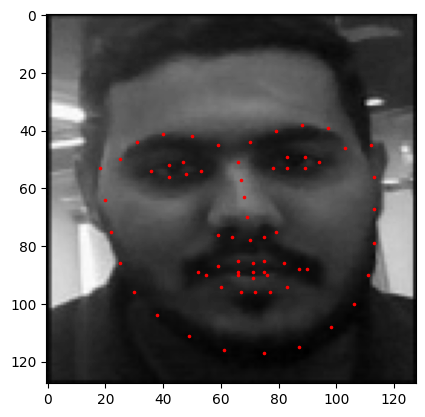

torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
Predicted class: 3_Ali amaan at i:6


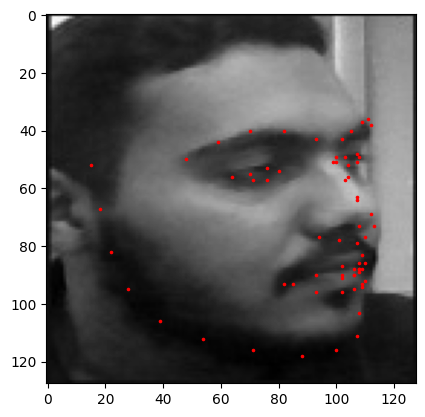

torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
Predicted class: 0_Abbas at i:16


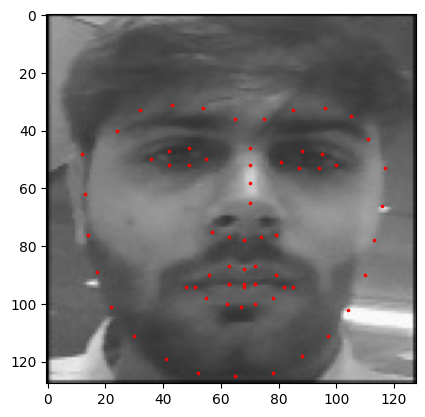

torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
Predicted class: 3_Ali amaan at i:19


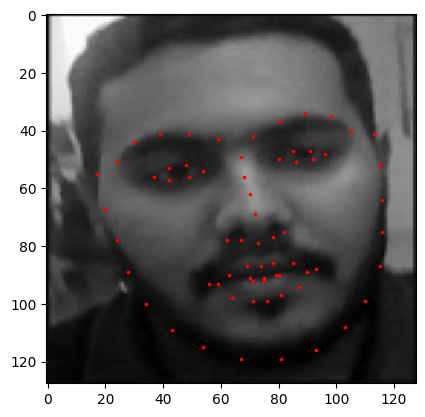

torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
Predicted class: 0_Abbas at i:29


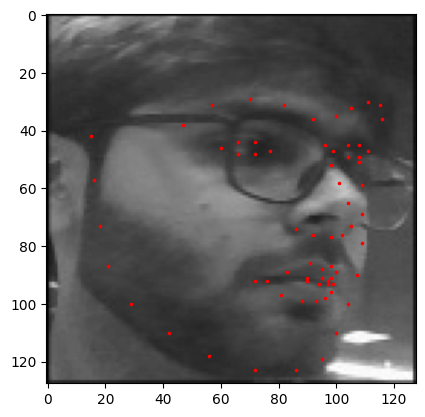

torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
Predicted class: 20_muhammad_bilal at i:42


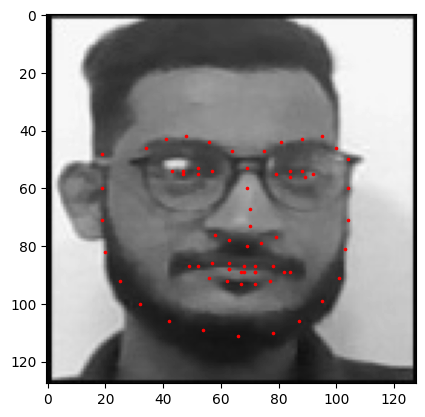

torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
Predicted class: 10_talal at i:47


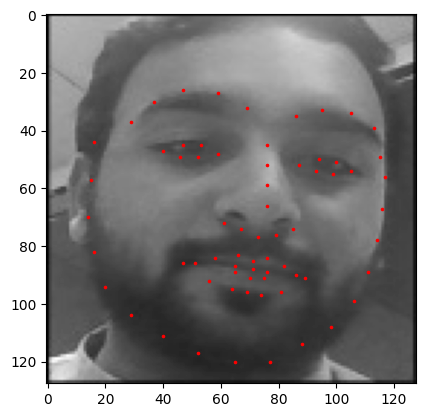

torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
Predicted class: 3_Ali amaan at i:52


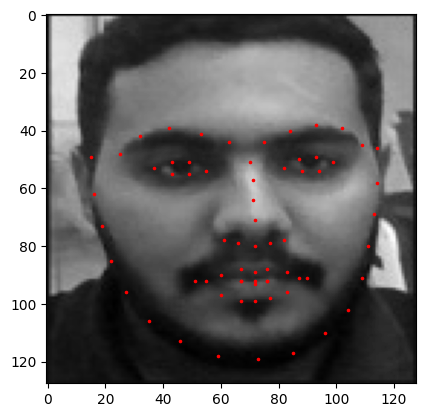

torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
Predicted class: 10_talal at i:65


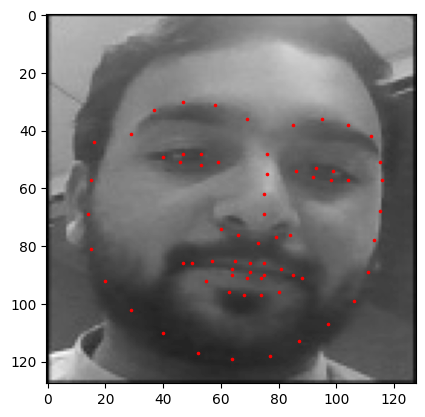

torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
Predicted class: 20_muhammad_bilal at i:72


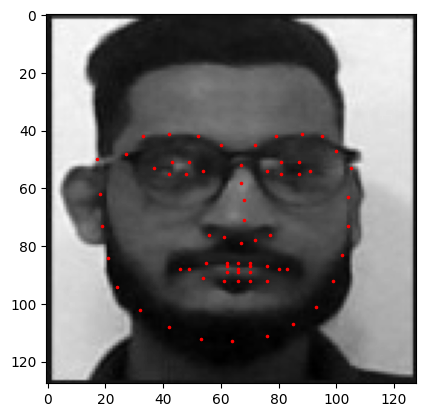

torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
Predicted class: 20_muhammad_bilal at i:74


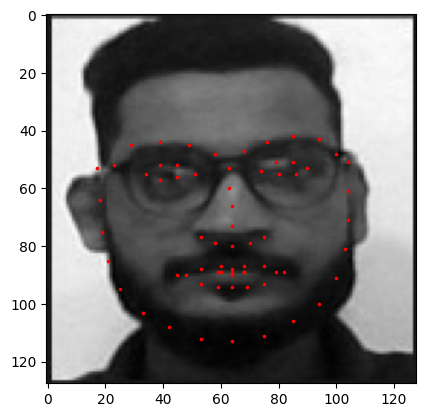

torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
Predicted class: 10_talal at i:93


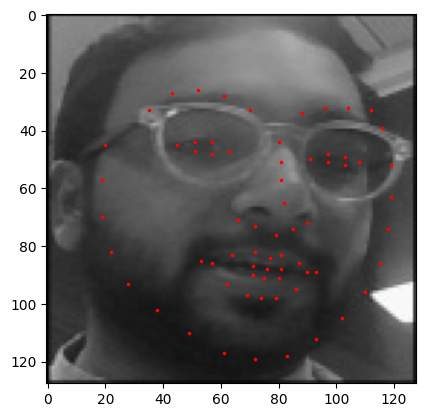

torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
Predicted class: 10_talal at i:98


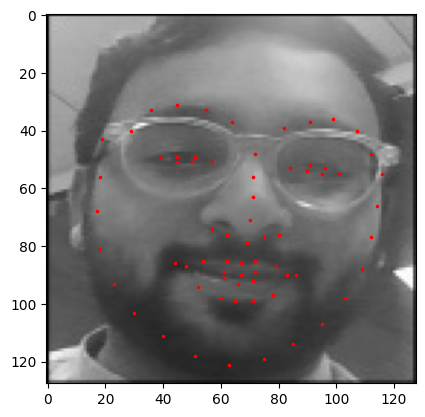

torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
Predicted class: 6_jahanzaib at i:119


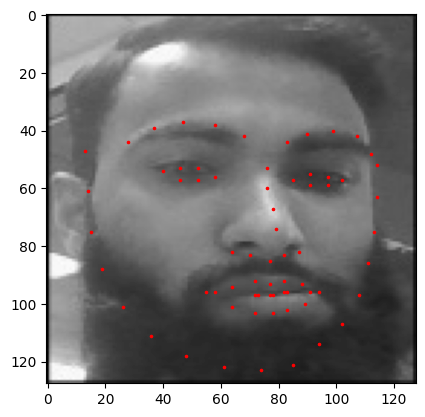

torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
Predicted class: 7_musaddiq at i:121


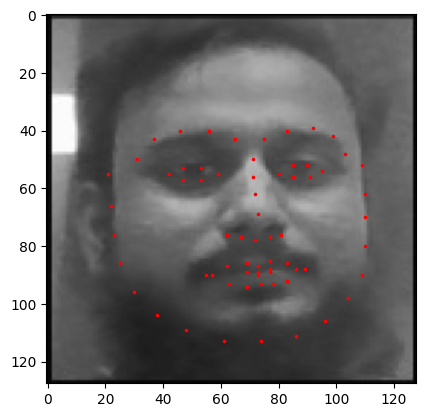

torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
Predicted class: 20_muhammad_bilal at i:129


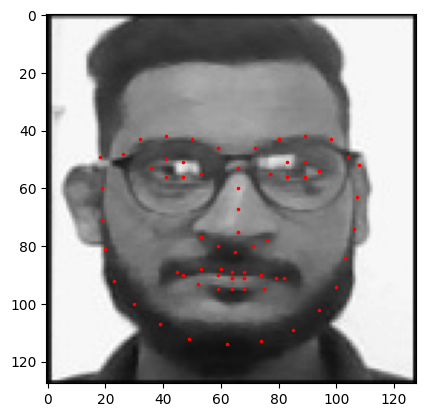

torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
Predicted class: 3_Ali amaan at i:141


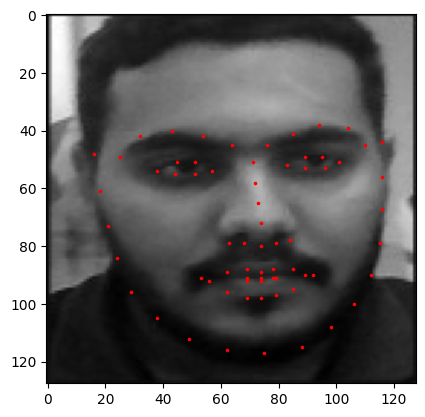

torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
Predicted class: 7_musaddiq at i:147


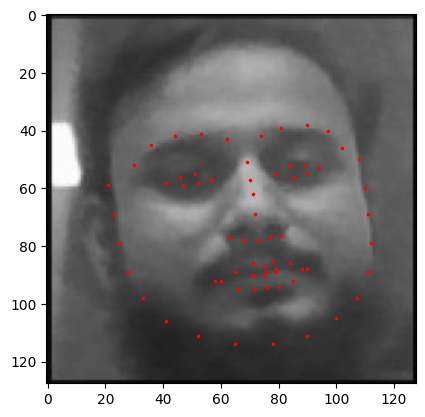

torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
Predicted class: 4_basit at i:149


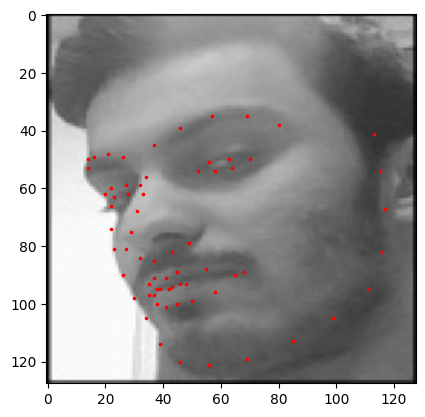

torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
Predicted class: 3_Ali amaan at i:159


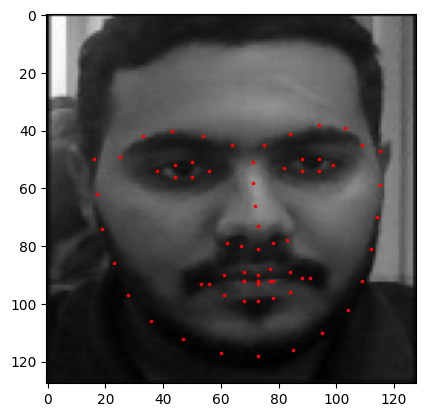

torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
Predicted class: 3_Ali amaan at i:174


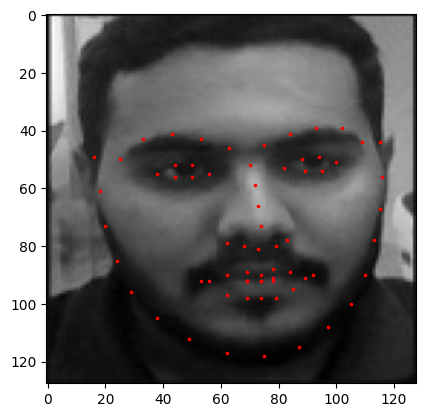

torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([

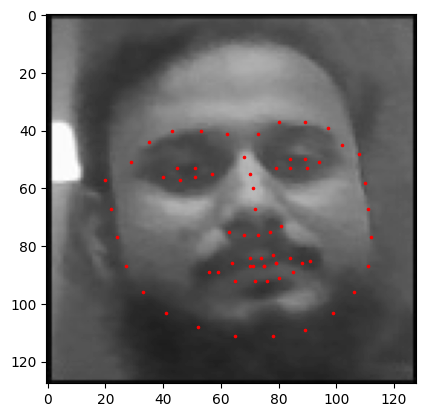

torch.Size([1, 1, 68, 2])
Predicted class: 20_muhammad_bilal at i:218


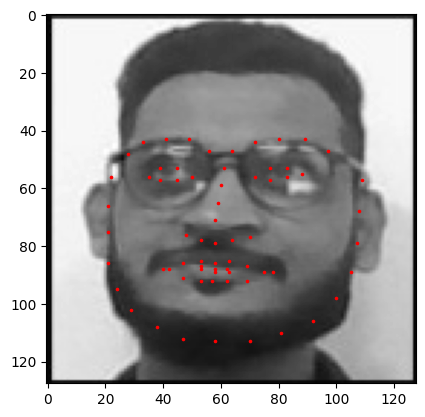

torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
Predicted class: 20_muhammad_bilal at i:239


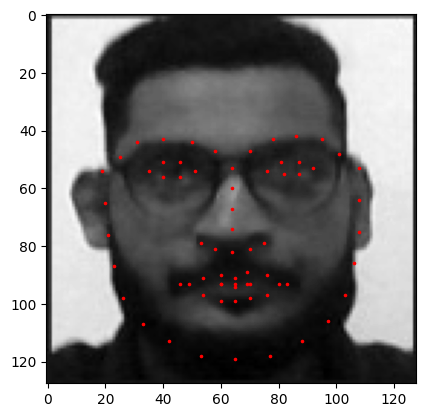

torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
Predicted class: 3_Ali amaan at i:252


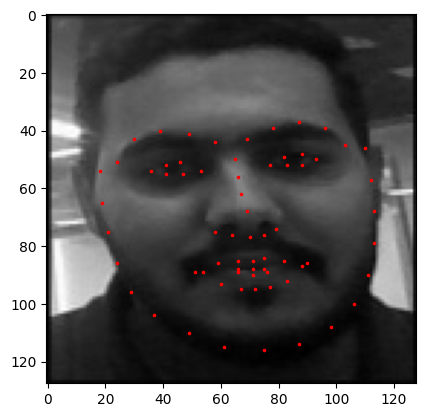

torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
Predicted class: 6_jahanzaib at i:257


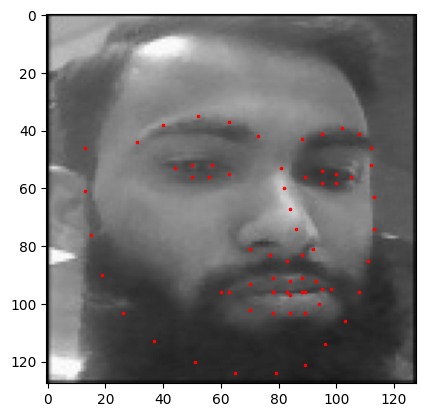

torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
Predicted class: 3_Ali amaan at i:259


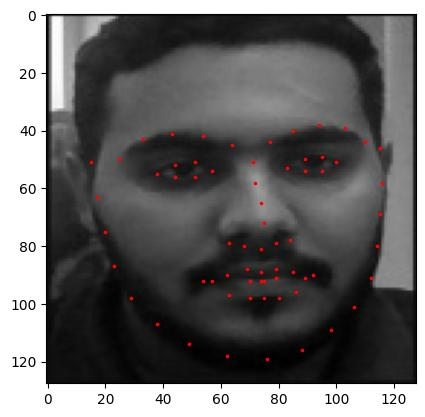

torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
Predicted class: 6_jahanzaib at i:273


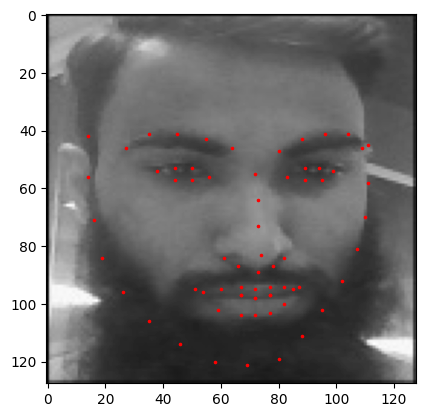

torch.Size([1, 1, 68, 2])
Predicted class: 20_muhammad_bilal at i:274


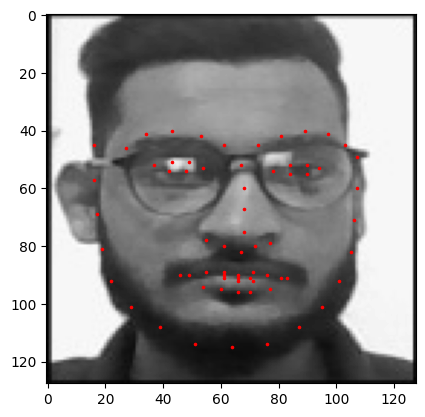

torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
Predicted class: 0_Abbas at i:276


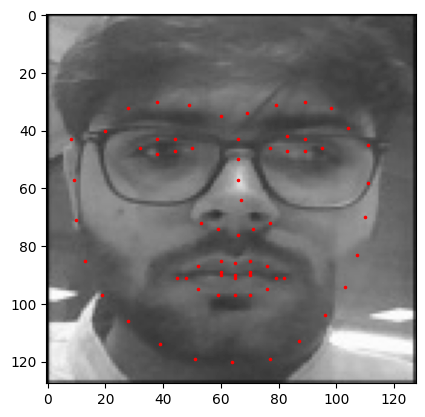

torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
Predicted class: 1_abdullah at i:281


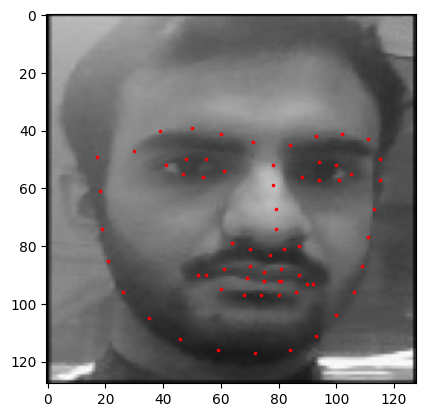

torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
Predicted class: 0_Abbas at i:303


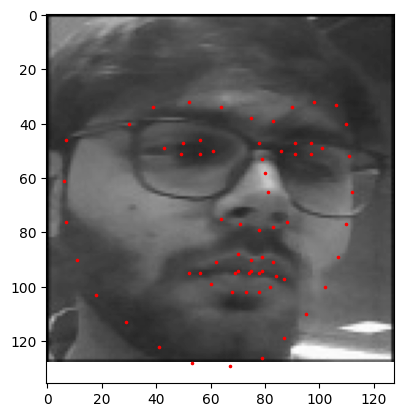

torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
Predicted class: 10_talal at i:309


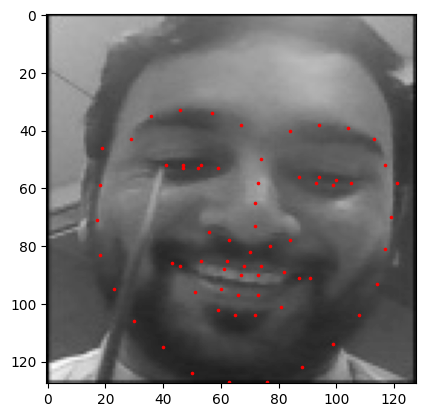

torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
Predicted class: 1_abdullah at i:314


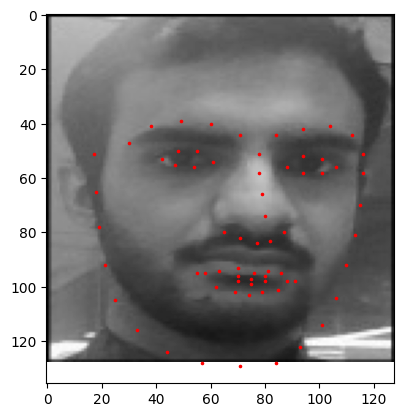

torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
Predicted class: 3_Ali amaan at i:330


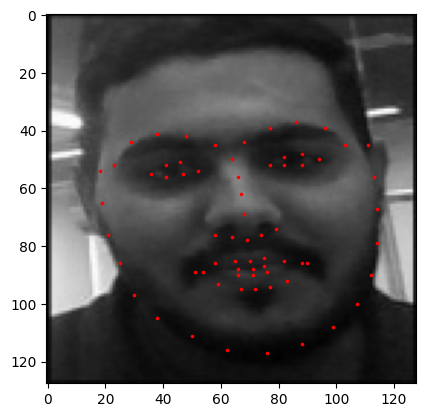

torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
Predicted class: 0_Abbas at i:338


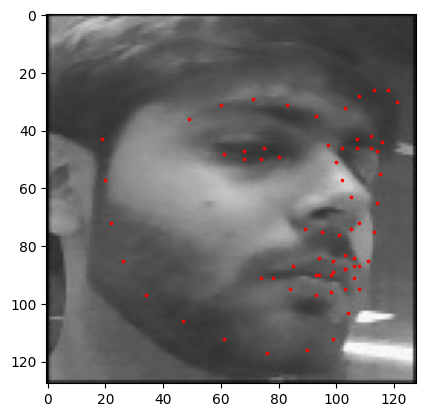

torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
Predicted class: 3_Ali amaan at i:342


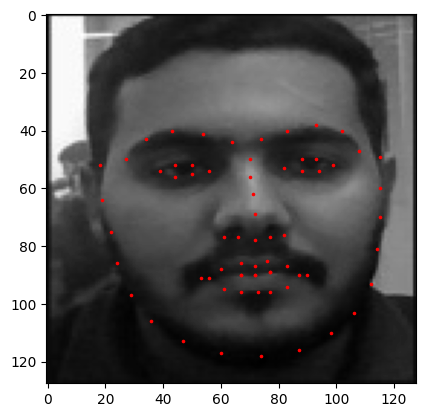

torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
Predicted class: 3_Ali amaan at i:352


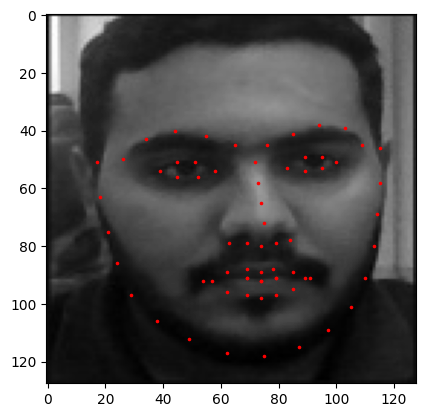

torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
Predicted class: 1_abdullah at i:384


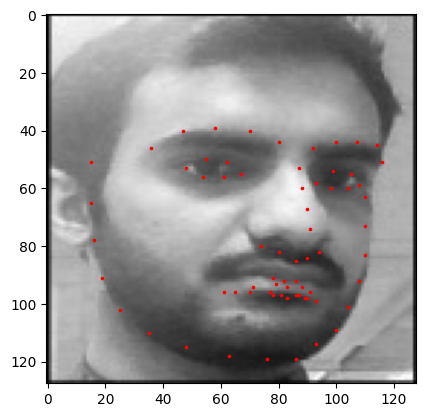

torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
Predicted class: 1_abdullah at i:390


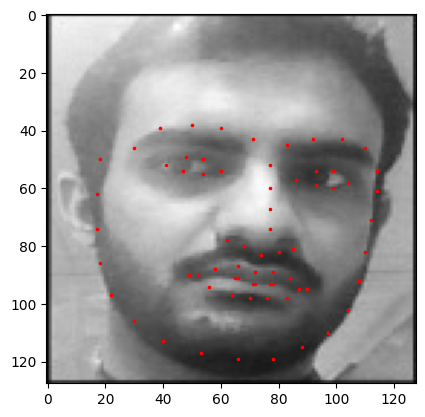

torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
Predicted class: 6_jahanzaib at i:396


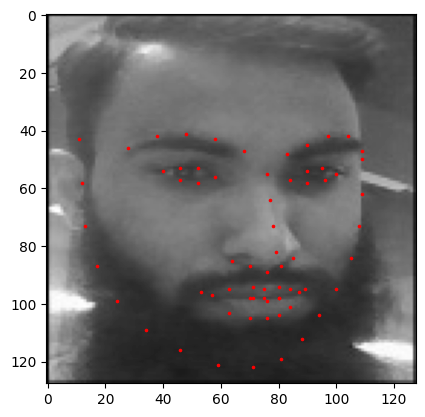

torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
Predicted class: 10_talal at i:409


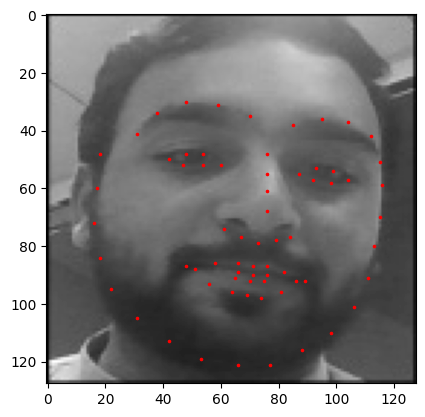

torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
Predicted class: 10_talal at i:415


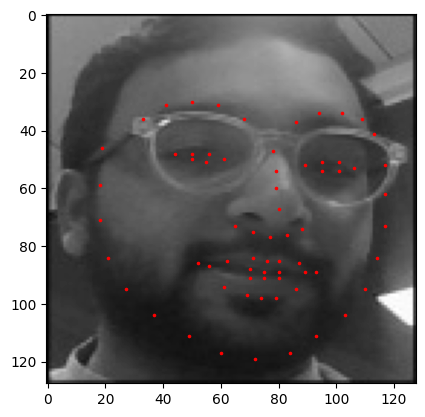

torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
Predicted class: 3_Ali amaan at i:433


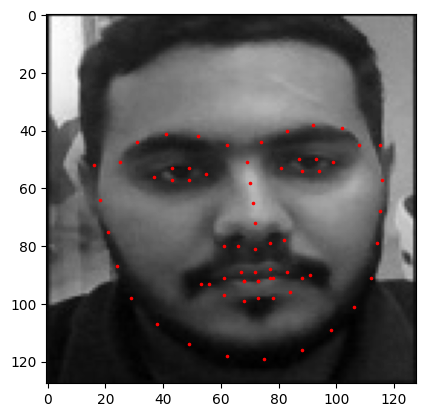

torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
Predicted class: 0_Abbas at i:451


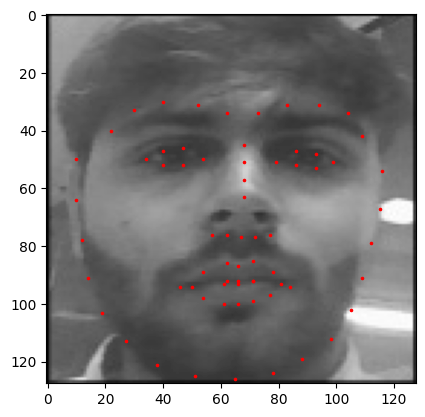

torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
Predicted class: 0_Abbas at i:453


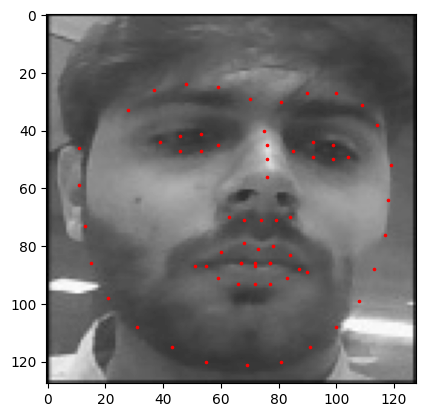

torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
Predicted class: 20_muhammad_bilal at i:455


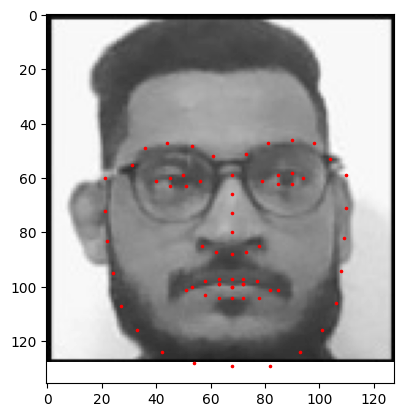

torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
Predicted class: 20_muhammad_bilal at i:491


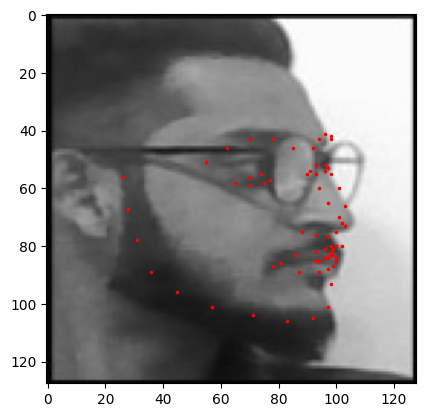

torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
Predicted class: 3_Ali amaan at i:496


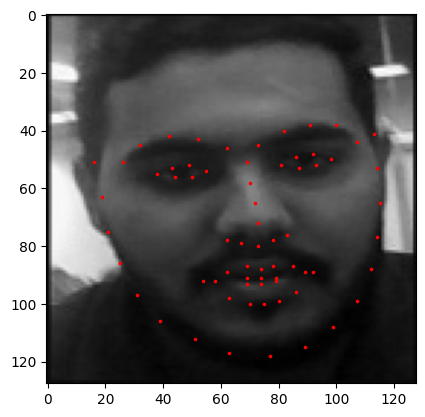

torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
torch.Size([1, 1, 68, 2])
Predicted class: 20_muhammad_bilal at i:504


KeyboardInterrupt: 

In [17]:
for i in range(1):
    visualize_predictions(model, dataloader_test)


In [5]:
# Load the checkpoint
checkpoint = torch.load("./weights/weight_basic.pth")

# Restore model and optimizer states
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Optionally, restore other data
epoch = checkpoint['epoch']
loss = checkpoint['loss']

NameError: name 'model' is not defined

In [ ]:
visualize_predictions(model, dataloader)